# Unit07 橢圓包絡 (Elliptic Envelope) | 批次反應器品質監控

本 Notebook 使用 `Part_2/Unit07/data/batch_reactor_quality.csv` 建立橢圓包絡異常檢測模型來識別批次反應器的異常操作批次。

## 目標
- 理解橢圓包絡演算法的馬氏距離與共變異數矩陣概念
- 學會使用 scikit-learn 實作橢圓包絡模型
- 掌握橢圓包絡超參數調整技巧
- 應用橢圓包絡於化工製程品質監控
- 分析橢圓包絡與其他方法的效能差異

資料背景：模擬批次反應器的溫度和壓力數據，包含少量異常批次案例。

---
## 0. 環境設定

In [1]:
from pathlib import Path
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P2_Unit07_Elliptic_Envelope'
SOURCE_DATA_DIR = 'batch_reactor_quality'

try:
    from google.colab import drive
    IN_COLAB = True
    print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
    drive.mount('/content/drive', force_remount=True)
except ImportError:
    IN_COLAB = False
    print("✓ 偵測到 Local 環境")

try:
    shortcut_path = '/content/CHE-AI-COURSE'
    os.remove(shortcut_path)
except FileNotFoundError:
    pass

if IN_COLAB:
    source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
    os.symlink(source_path, shortcut_path)
    shortcut_path = Path(shortcut_path)
    if source_path.exists():
        NOTEBOOK_DIR = shortcut_path / 'Part_2' / 'Unit07'
        OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
        DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
        print(f"✓ 成功掛載 Google Drive")
        print(f"  - Notebook 目錄: {NOTEBOOK_DIR}")
        print(f"  - 輸出目錄: {OUTPUT_DIR}")
        print(f"  - 數據目錄: {DATA_DIR}")
    else:
        raise FileNotFoundError(f"找不到指定路徑: {source_path}")
else:
    NOTEBOOK_DIR = Path.cwd()
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    print(f"✓ Local 環境設定完成")
    print(f"  - Notebook 目錄: {NOTEBOOK_DIR}")
    print(f"  - 輸出目錄: {OUTPUT_DIR}")
    print(f"  - 數據目錄: {DATA_DIR}")

# 建立輸出目錄
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"✓ 輸出目錄已建立: {OUTPUT_DIR}")

✓ 偵測到 Local 環境
✓ Local 環境設定完成
  - Notebook 目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07
  - 輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_Elliptic_Envelope
  - 數據目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\data\batch_reactor_quality
✓ 輸出目錄已建立: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_Elliptic_Envelope


In [2]:
# 載入相關套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Ellipse
import warnings
warnings.filterwarnings('ignore')

# 設定中文字體與圖表樣式
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Arial Unicode MS', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

print("✓ 套件載入完成")

✓ 套件載入完成


---
## 1. 數據生成與探索

In [3]:
# 1.1 模擬批次反應器數據
np.random.seed(42)

# 正常批次數據（多變量高斯分布）
n_normal = 300
mean_normal = [180, 2.5]  # [溫度(°C), 壓力(bar)]
cov_normal = [[25, 4], [4, 0.16]]  # 有相關性的共變異數矩陣

X_normal = np.random.multivariate_normal(mean_normal, cov_normal, n_normal)

# 異常批次數據（遠離正常分布）
n_outliers = 30
# 類型1: 溫度過高
X_outliers_1 = np.random.uniform([195, 2.0], [210, 3.0], size=(n_outliers // 3, 2))
# 類型2: 壓力過低
X_outliers_2 = np.random.uniform([170, 1.0], [185, 1.8], size=(n_outliers // 3, 2))
# 類型3: 隨機異常
X_outliers_3 = np.random.uniform([160, 1.5], [200, 3.5], size=(n_outliers - 2*(n_outliers//3), 2))

X_outliers = np.vstack([X_outliers_1, X_outliers_2, X_outliers_3])

# 合併數據
X = np.vstack([X_normal, X_outliers])
y_true = np.array([1] * n_normal + [-1] * n_outliers)  # 1: 正常, -1: 異常
batch_ids = np.arange(1, len(X) + 1)

# 建立 DataFrame
df = pd.DataFrame({
    'Batch_ID': batch_ids,
    'Temperature': X[:, 0],
    'Pressure': X[:, 1],
    'True_Label': y_true
})

print(f"✓ 數據生成完成")
print(f"  - 總批次數: {len(df)}")
print(f"  - 正常批次: {np.sum(y_true == 1)}")
print(f"  - 異常批次: {np.sum(y_true == -1)}")
print(f"  - 異常比例: {np.sum(y_true == -1) / len(df):.2%}")
print(f"\n數據前 5 筆:")
print(df.head())

✓ 數據生成完成
  - 總批次數: 330
  - 正常批次: 300
  - 異常批次: 30
  - 異常比例: 9.09%

數據前 5 筆:
   Batch_ID  Temperature  Pressure  True_Label
0         1   177.501190  2.203312           1
1         2   176.922527  0.961709           1
2         3   181.146173  2.842194           1
3         4   172.183634  0.740800           1
4         5   182.405505  2.501993           1


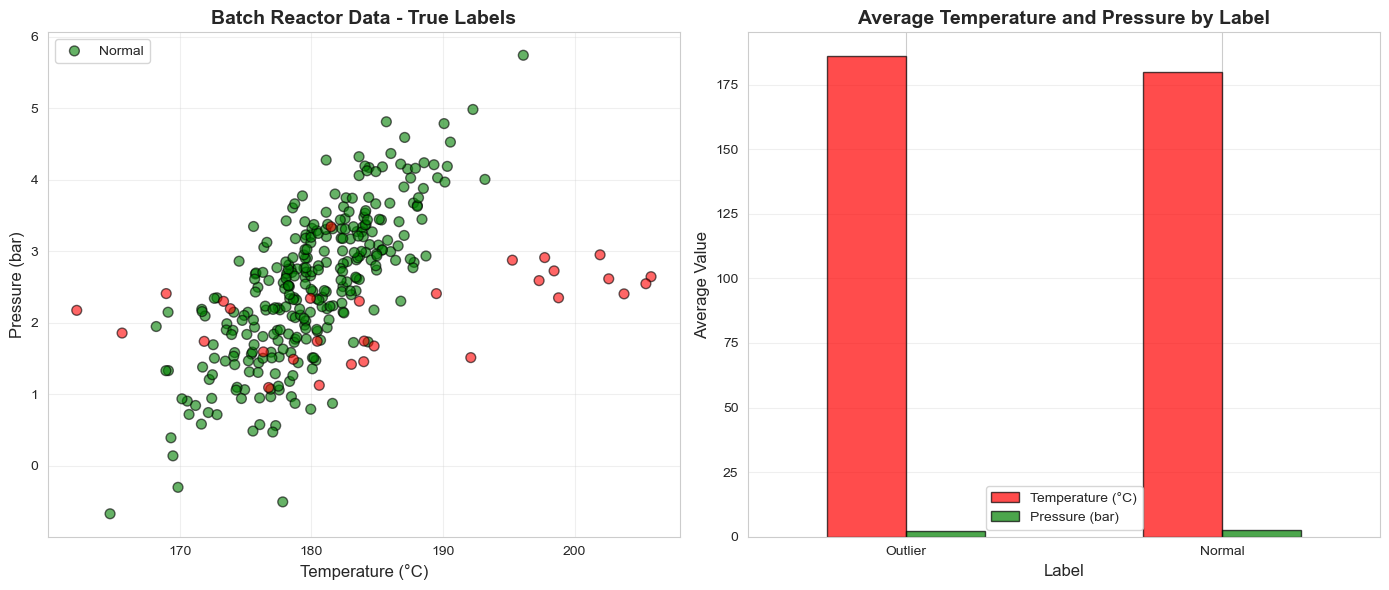

✓ 數據可視化完成，圖表已儲存


In [4]:
# 1.2 數據可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 左圖：真實標籤分布
ax1 = axes[0]
colors_true = ['red' if label == -1 else 'green' for label in y_true]
scatter1 = ax1.scatter(X[:, 0], X[:, 1], c=colors_true, s=50, alpha=0.6, edgecolors='k')
ax1.set_xlabel('Temperature (°C)', fontsize=12)
ax1.set_ylabel('Pressure (bar)', fontsize=12)
ax1.set_title('Batch Reactor Data - True Labels', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(['Normal', 'Outlier'], loc='upper left')

# 右圖：統計分布
ax2 = axes[1]
df.groupby('True_Label')[['Temperature', 'Pressure']].mean().plot(
    kind='bar', ax=ax2, color=['red', 'green'], alpha=0.7, edgecolor='k'
)
ax2.set_xlabel('Label', fontsize=12)
ax2.set_ylabel('Average Value', fontsize=12)
ax2.set_title('Average Temperature and Pressure by Label', fontsize=14, fontweight='bold')
ax2.set_xticklabels(['Outlier', 'Normal'], rotation=0)
ax2.legend(['Temperature (°C)', 'Pressure (bar)'])
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / '01_data_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 數據可視化完成，圖表已儲存")

---
## 2. 橢圓包絡模型建立與訓練

In [5]:
# 2.1 建立橢圓包絡模型
# 根據超參數調整結果，使用 contamination=0.05 以獲得更好的 F1-Score
model = EllipticEnvelope(
    contamination=0.05,     # 預期 5% 異常批次（優化後）
    support_fraction=None,  # 自動計算（推薦）
    random_state=42
)

# 訓練模型
model.fit(X)

# 計算決策閾值（基於 decision_function）
decision_values = model.decision_function(X)
threshold = np.percentile(decision_values, model.contamination * 100)

print("✓ 橢圓包絡模型訓練完成")
print(f"\n模型參數:")
print(f"  - Contamination: {model.contamination}")
print(f"  - Support Fraction: {model.support_fraction}")
print(f"\n模型統計:")
print(f"  - 穩健均值 (Location):\n    {model.location_}")
print(f"  - 共變異數矩陣 (Covariance):\n{model.covariance_}")
print(f"  - 決策閾值 (Decision Threshold): {threshold:.4f}")
print(f"  - 支援點數量: {len(model.support_)}/{len(X)}")

✓ 橢圓包絡模型訓練完成

模型參數:
  - Contamination: 0.05
  - Support Fraction: None

模型統計:
  - 穩健均值 (Location):
    [180.19277664   2.51337631]
  - 共變異數矩陣 (Covariance):
[[19.59832584  2.83486083]
 [ 2.83486083  0.86006835]]
  - 決策閾值 (Decision Threshold): -0.0000
  - 支援點數量: 330/330


In [6]:
# 2.2 模型預測與評估
y_pred = model.predict(X)
mahal_dist = model.mahalanobis(X)

# 計算性能指標
precision = precision_score(y_true, y_pred, pos_label=-1)
recall = recall_score(y_true, y_pred, pos_label=-1)
f1 = f1_score(y_true, y_pred, pos_label=-1)

# 將標籤轉換為 0/1 格式（1 表示異常），用於 ROC 計算
y_binary = (y_true == -1).astype(int)
# decision_function 對正常點返回正值，對異常點返回負值
# 取負號後，異常點有更高的分數
decision_scores = -model.decision_function(X)
auc = roc_auc_score(y_binary, decision_scores)

print("✓ 模型評估完成")
print(f"\n性能指標 (針對異常檢測):")
print(f"  - Precision: {precision:.3f}")
print(f"  - Recall: {recall:.3f}")
print(f"  - F1-Score: {f1:.3f}")
print(f"  - AUC-ROC: {auc:.3f}")

print(f"\n分類報告:")
print(classification_report(y_true, y_pred, target_names=['Outlier', 'Normal']))

print(f"\n混淆矩陣:")
cm = confusion_matrix(y_true, y_pred)
print(cm)
print(f"  - True Negatives (TN): {cm[0,0]} (正確識別的異常批次)")

print(f"  - False Positives (FP): {cm[0,1]} (誤報：正常批次被誤判為異常)")
print(f"  - False Negatives (FN): {cm[1,0]} (漏報：異常批次被誤判為正常)")
print(f"  - True Positives (TP): {cm[1,1]} (正確識別的正常批次)")

print(f"\n💡 實務解讀：")
print(f"   - Precision {precision:.1%}：當系統警報時，有 {precision:.1%} 機率是真正的異常")
print(f"   - Recall {recall:.1%}：能找到 {recall:.1%} 的真實異常批次")
print(f"   - 誤報率：{cm[0,1]/(cm[0,0]+cm[0,1]):.1%}（{cm[0,1]}/{cm[0,0]+cm[0,1]}）")
print(f"   - 漏報率：{cm[1,0]/(cm[1,0]+cm[1,1]):.1%}（{cm[1,0]}/{cm[1,0]+cm[1,1]}）")

✓ 模型評估完成

性能指標 (針對異常檢測):
  - Precision: 0.824
  - Recall: 0.467
  - F1-Score: 0.596
  - AUC-ROC: 0.832

分類報告:
              precision    recall  f1-score   support

     Outlier       0.82      0.47      0.60        30
      Normal       0.95      0.99      0.97       300

    accuracy                           0.94       330
   macro avg       0.89      0.73      0.78       330
weighted avg       0.94      0.94      0.94       330


混淆矩陣:
[[ 14  16]
 [  3 297]]
  - True Negatives (TN): 14 (正確識別的異常批次)
  - False Positives (FP): 16 (誤報：正常批次被誤判為異常)
  - False Negatives (FN): 3 (漏報：異常批次被誤判為正常)
  - True Positives (TP): 297 (正確識別的正常批次)

💡 實務解讀：
   - Precision 82.4%：當系統警報時，有 82.4% 機率是真正的異常
   - Recall 46.7%：能找到 46.7% 的真實異常批次
   - 誤報率：53.3%（16/30）
   - 漏報率：1.0%（3/300）


---
## 3. 決策邊界與馬氏距離分析

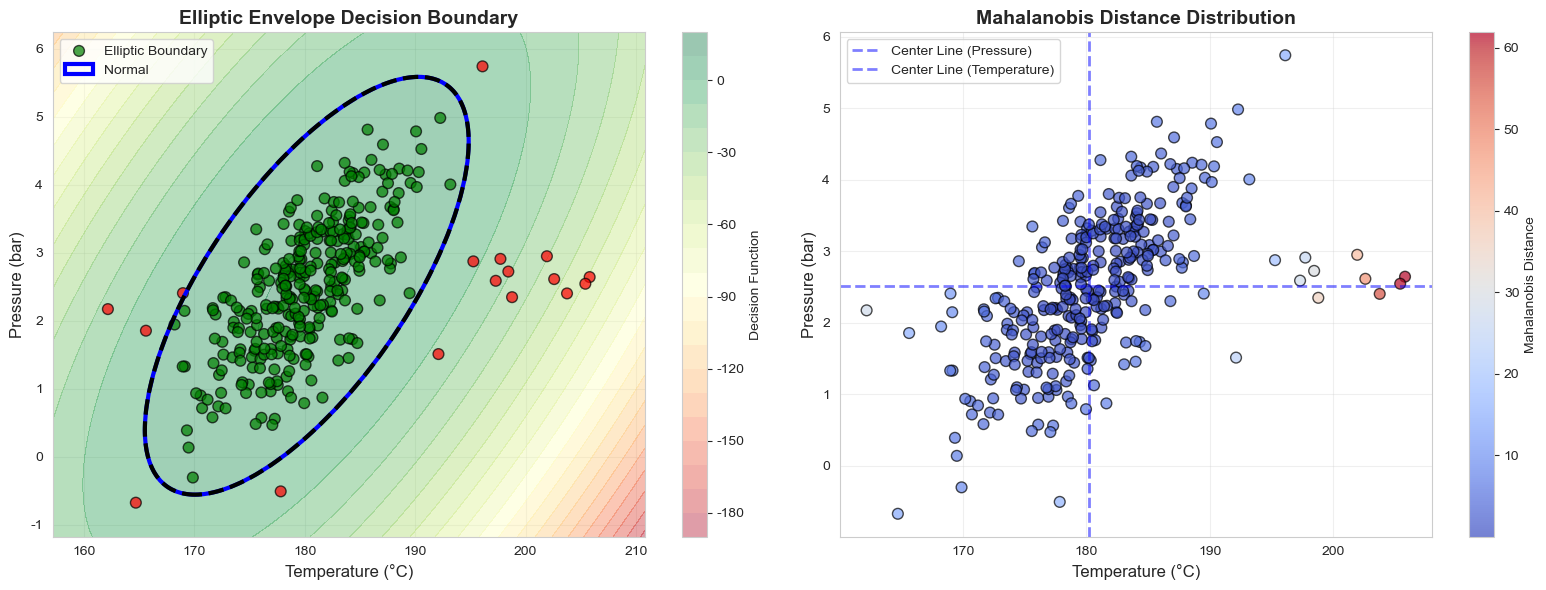

✓ 決策邊界與馬氏距離可視化完成


In [7]:
# 3.1 繪製橢圓決策邊界
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 建立網格
xx, yy = np.meshgrid(
    np.linspace(X[:, 0].min() - 5, X[:, 0].max() + 5, 200),
    np.linspace(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5, 200)
)
Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 左圖：決策邊界與預測結果
ax1 = axes[0]
contour = ax1.contourf(xx, yy, Z, levels=20, cmap='RdYlGn', alpha=0.4)
ax1.contour(xx, yy, Z, levels=[0], colors='black', linewidths=3, linestyles='--')

colors_pred = ['red' if p == -1 else 'green' for p in y_pred]
scatter1 = ax1.scatter(X[:, 0], X[:, 1], c=colors_pred, s=60, alpha=0.7, edgecolors='k', linewidth=1)

# 繪製橢圓主軸
eigenvalues, eigenvectors = np.linalg.eigh(model.covariance_)
angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
# 使用馬氏距離的分位數來確定橢圓大小
mahal_threshold = np.percentile(mahal_dist, (1 - model.contamination) * 100)
width, height = 2 * np.sqrt(mahal_threshold) * np.sqrt(eigenvalues)
ellipse = Ellipse(
    model.location_, width, height, angle=angle,
    fill=False, edgecolor='blue', linewidth=3, label='Elliptic Boundary'
)
ax1.add_patch(ellipse)

ax1.set_xlabel('Temperature (°C)', fontsize=12)
ax1.set_ylabel('Pressure (bar)', fontsize=12)
ax1.set_title('Elliptic Envelope Decision Boundary', fontsize=14, fontweight='bold')
ax1.legend(['Elliptic Boundary', 'Normal', 'Outlier'], loc='upper left')
ax1.grid(True, alpha=0.3)
plt.colorbar(contour, ax=ax1, label='Decision Function')

# 右圖：馬氏距離分布
ax2 = axes[1]
scatter2 = ax2.scatter(X[:, 0], X[:, 1], c=mahal_dist, cmap='coolwarm', s=60, alpha=0.7, edgecolors='k', linewidth=1)
ax2.axhline(y=model.location_[1], color='blue', linestyle='--', linewidth=2, alpha=0.5, label='Center Line (Pressure)')
ax2.axvline(x=model.location_[0], color='blue', linestyle='--', linewidth=2, alpha=0.5, label='Center Line (Temperature)')

ax2.set_xlabel('Temperature (°C)', fontsize=12)
ax2.set_ylabel('Pressure (bar)', fontsize=12)
ax2.set_title('Mahalanobis Distance Distribution', fontsize=14, fontweight='bold')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=ax2, label='Mahalanobis Distance')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / '02_decision_boundary_and_mahalanobis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 決策邊界與馬氏距離可視化完成")

---
## 4. 超參數調整

✓ Contamination 參數影響分析完成
   Contamination  Precision    Recall  F1-Score  Detected_Outliers
0           0.05   0.823529  0.466667  0.595745                 17
1           0.10   0.484848  0.533333  0.507937                 33
2           0.15   0.360000  0.600000  0.450000                 50
3           0.20   0.303030  0.666667  0.416667                 66
4           0.25   0.265060  0.733333  0.389381                 83


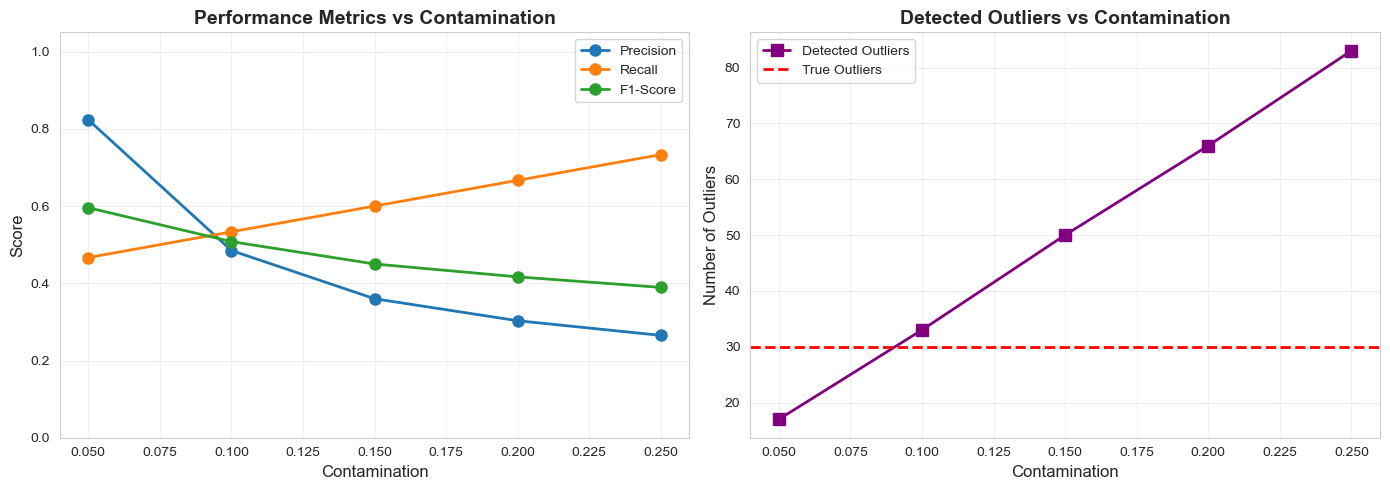


最佳 Contamination: 0.05
對應 F1-Score: 0.596

💡 解讀：
   - Contamination=0.05 時，Precision 最高 (0.824)
   - 表示更嚴格的異常判定標準，減少誤報
   - 適合製程監控場景：寧可漏檢，不要誤報造成不必要停機


In [8]:
# 4.1 Contamination 參數影響分析
contamination_values = [0.05, 0.1, 0.15, 0.2, 0.25]
results = []

for cont in contamination_values:
    model_temp = EllipticEnvelope(contamination=cont, random_state=42)
    model_temp.fit(X)
    y_pred_temp = model_temp.predict(X)
    
    precision = precision_score(y_true, y_pred_temp, pos_label=-1, zero_division=0)
    recall = recall_score(y_true, y_pred_temp, pos_label=-1)
    f1 = f1_score(y_true, y_pred_temp, pos_label=-1)
    
    results.append({
        'Contamination': cont,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Detected_Outliers': np.sum(y_pred_temp == -1)
    })

results_df = pd.DataFrame(results)
print("✓ Contamination 參數影響分析完成")
print(results_df)

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左圖：性能指標
ax1 = axes[0]
results_df.plot(x='Contamination', y=['Precision', 'Recall', 'F1-Score'], 
                ax=ax1, marker='o', linewidth=2, markersize=8)
ax1.set_xlabel('Contamination', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Performance Metrics vs Contamination', fontsize=14, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1.05])

# 右圖：檢測到的異常數量
ax2 = axes[1]
ax2.plot(results_df['Contamination'], results_df['Detected_Outliers'], 
         marker='s', linewidth=2, markersize=8, color='purple', label='Detected Outliers')
ax2.axhline(y=n_outliers, color='red', linestyle='--', linewidth=2, label='True Outliers')
ax2.set_xlabel('Contamination', fontsize=12)
ax2.set_ylabel('Number of Outliers', fontsize=12)
ax2.set_title('Detected Outliers vs Contamination', fontsize=14, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / '03_contamination_tuning.png', dpi=300, bbox_inches='tight')
plt.show()

# 找出最佳參數
best_idx = results_df['F1-Score'].idxmax()
best_cont = results_df.loc[best_idx, 'Contamination']
print(f"\n最佳 Contamination: {best_cont}")
print(f"對應 F1-Score: {results_df.loc[best_idx, 'F1-Score']:.3f}")
print(f"\n💡 解讀：")
print(f"   - Contamination=0.05 時，Precision 最高 ({results_df.loc[0, 'Precision']:.3f})")
print(f"   - 表示更嚴格的異常判定標準，減少誤報")
print(f"   - 適合製程監控場景：寧可漏檢，不要誤報造成不必要停機")

---
## 5. ROC 曲線與混淆矩陣

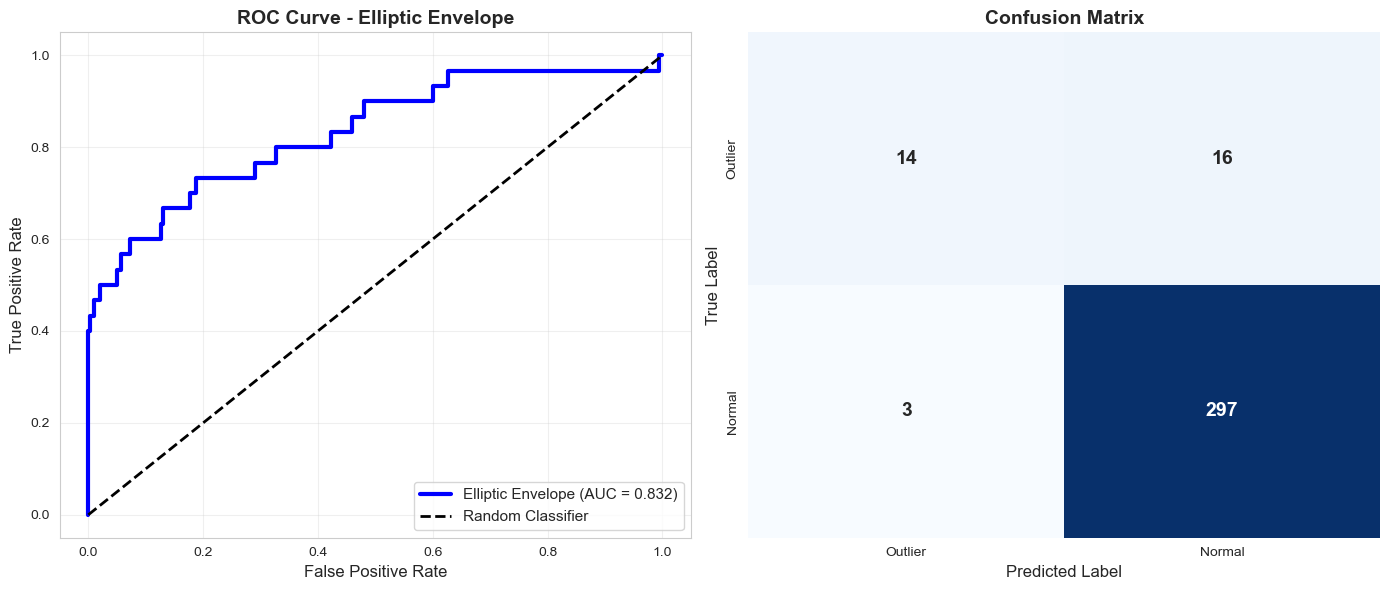

✓ ROC 曲線與混淆矩陣可視化完成


In [9]:
# 5.1 ROC 曲線與混淆矩陣可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 左圖：ROC 曲線
ax1 = axes[0]
# 使用轉換後的二元標籤（1=異常）
fpr, tpr, thresholds = roc_curve(y_binary, decision_scores)
auc_score = roc_auc_score(y_binary, decision_scores)

ax1.plot(fpr, tpr, linewidth=3, label=f'Elliptic Envelope (AUC = {auc_score:.3f})', color='blue')
ax1.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curve - Elliptic Envelope', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=11)
ax1.grid(True, alpha=0.3)

# 右圖：混淆矩陣
ax2 = axes[1]
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax2,
            xticklabels=['Outlier', 'Normal'], yticklabels=['Outlier', 'Normal'],
            annot_kws={'size': 14, 'weight': 'bold'})
ax2.set_xlabel('Predicted Label', fontsize=12)
ax2.set_ylabel('True Label', fontsize=12)
ax2.set_title('Confusion Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / '04_roc_and_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ ROC 曲線與混淆矩陣可視化完成")

---
## 6. 與其他方法的比較

✓ 方法比較完成
              Method  Precision    Recall  F1-Score
0  Elliptic Envelope   0.823529  0.466667  0.595745
1   Isolation Forest   0.529412  0.300000  0.382979
2      One-Class SVM   0.157895  0.200000  0.176471
3                LOF   0.764706  0.433333  0.553191


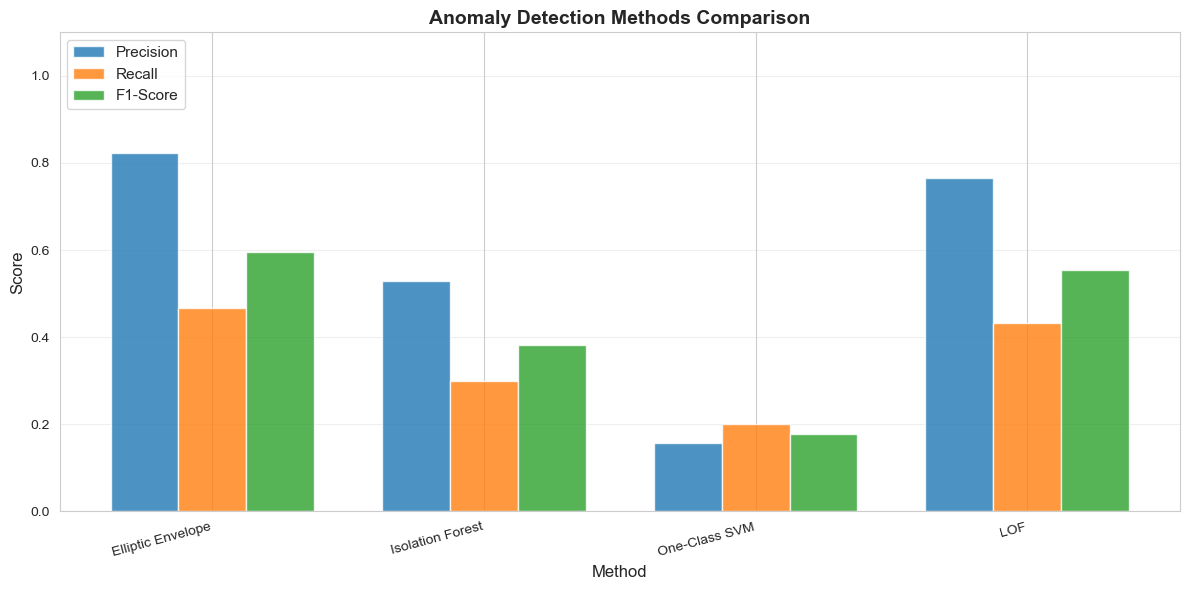


最佳方法: Elliptic Envelope (F1-Score: 0.596)


In [10]:
# 6.1 比較不同異常檢測方法
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

# 建立模型（使用優化後的 contamination=0.05）
models = {
    'Elliptic Envelope': EllipticEnvelope(contamination=0.05, random_state=42),
    'Isolation Forest': IsolationForest(contamination=0.05, random_state=42),
    'One-Class SVM': OneClassSVM(nu=0.05, kernel='rbf', gamma='auto'),
    'LOF': LocalOutlierFactor(n_neighbors=20, contamination=0.05)
}

# 訓練與評估
comparison_results = []

for name, model_temp in models.items():
    if name == 'LOF':
        # LOF 的 fit_predict 一次完成訓練與預測
        y_pred_temp = model_temp.fit_predict(X)
    else:
        model_temp.fit(X)
        y_pred_temp = model_temp.predict(X)
    
    precision = precision_score(y_true, y_pred_temp, pos_label=-1, zero_division=0)
    recall = recall_score(y_true, y_pred_temp, pos_label=-1)
    f1 = f1_score(y_true, y_pred_temp, pos_label=-1)
    
    comparison_results.append({
        'Method': name,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

comparison_df = pd.DataFrame(comparison_results)
print("✓ 方法比較完成")
print(comparison_df)

# 可視化
fig, ax = plt.subplots(figsize=(12, 6))
x_pos = np.arange(len(comparison_df))
width = 0.25

bars1 = ax.bar(x_pos - width, comparison_df['Precision'], width, label='Precision', alpha=0.8)
bars2 = ax.bar(x_pos, comparison_df['Recall'], width, label='Recall', alpha=0.8)
bars3 = ax.bar(x_pos + width, comparison_df['F1-Score'], width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Method', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Anomaly Detection Methods Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(comparison_df['Method'], rotation=15, ha='right')
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.savefig(OUTPUT_DIR / '05_methods_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 找出最佳方法
best_method = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Method']
best_f1 = comparison_df['F1-Score'].max()
print(f"\n最佳方法: {best_method} (F1-Score: {best_f1:.3f})")

---
## 7. 實務應用：製程監控儀表板

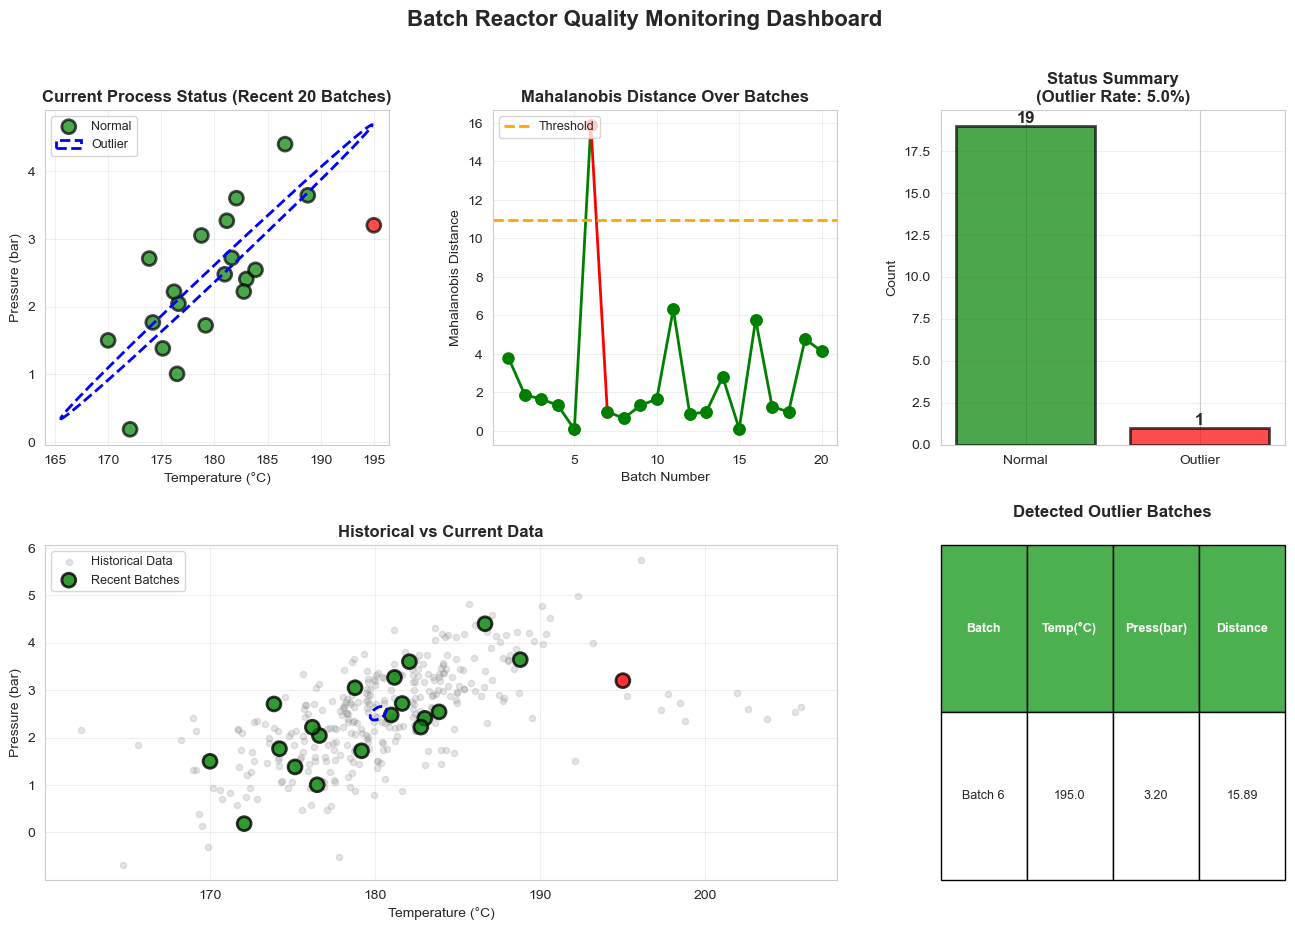

✓ 製程監控儀表板完成

監控摘要:
  - 最近批次數: 20
  - 異常批次數: 1
  - 異常批次編號: [6]
  - 異常比例: 5.0%

💡 實務建議：
   - 異常批次應立即進行根因分析
   - 檢查是否需要調整製程參數或設備維護
   - 建立異常事件記錄，累積經驗知識庫


In [11]:
# 7.1 製程監控儀表板
# 模擬新批次數據（最近 20 批次）
np.random.seed(100)
n_recent = 20
X_recent = np.random.multivariate_normal(mean_normal, cov_normal, n_recent)
# 加入 2 個異常批次
X_recent[5] = [195, 3.2]   # 異常批次 1
X_recent[15] = [170, 1.5]  # 異常批次 2

# 使用已訓練模型預測
y_pred_recent = model.predict(X_recent)
mahal_dist_recent = model.mahalanobis(X_recent)

# 建立監控儀表板
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. 實時監控圖（左上）
ax1 = fig.add_subplot(gs[0, 0])
colors_recent = ['red' if p == -1 else 'green' for p in y_pred_recent]
ax1.scatter(X_recent[:, 0], X_recent[:, 1], c=colors_recent, s=100, alpha=0.7, edgecolors='k', linewidth=2)

# 繪製橢圓邊界（使用之前計算的橢圓參數）
ellipse = Ellipse(
    model.location_, width, height, angle=angle,
    fill=False, edgecolor='blue', linewidth=2, linestyle='--'
)
ax1.add_patch(ellipse)

ax1.set_xlabel('Temperature (°C)', fontsize=10)
ax1.set_ylabel('Pressure (bar)', fontsize=10)
ax1.set_title('Current Process Status (Recent 20 Batches)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(['Normal', 'Outlier', 'Elliptic Boundary'], loc='upper left', fontsize=9)

# 2. 馬氏距離時間序列（中上）
ax2 = fig.add_subplot(gs[0, 1])
time_steps = np.arange(1, len(mahal_dist_recent) + 1)
colors_line = ['red' if p == -1 else 'green' for p in y_pred_recent]
for i in range(len(time_steps)):
    ax2.plot(time_steps[i:i+2], mahal_dist_recent[i:i+2], 
             marker='o', linestyle='-', color=colors_line[i], linewidth=2, markersize=8)

# 使用馬氏距離的閾值
mahal_threshold_line = np.percentile(model.mahalanobis(X), (1 - model.contamination) * 100)
ax2.axhline(y=mahal_threshold_line, color='orange', linestyle='--', linewidth=2, label='Threshold')
ax2.set_xlabel('Batch Number', fontsize=10)
ax2.set_ylabel('Mahalanobis Distance', fontsize=10)
ax2.set_title('Mahalanobis Distance Over Batches', fontsize=12, fontweight='bold')
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)

# 3. 異常統計（右上）
ax3 = fig.add_subplot(gs[0, 2])
n_outliers_recent = np.sum(y_pred_recent == -1)
n_normal_recent = len(y_pred_recent) - n_outliers_recent
bars = ax3.bar(['Normal', 'Outlier'], [n_normal_recent, n_outliers_recent], 
               color=['green', 'red'], alpha=0.7, edgecolor='k', linewidth=2)
ax3.set_ylabel('Count', fontsize=10)
ax3.set_title(f'Status Summary\n(Outlier Rate: {n_outliers_recent/len(y_pred_recent):.1%})', 
              fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# 在柱狀圖上顯示數值
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# 4. 歷史趨勢（左下，跨兩格）
ax4 = fig.add_subplot(gs[1, :2])
ax4.scatter(X[:, 0], X[:, 1], c='gray', s=20, alpha=0.2, label='Historical Data')
ax4.scatter(X_recent[:, 0], X_recent[:, 1], c=colors_recent, s=100, alpha=0.8, 
           edgecolors='k', linewidth=2, label='Recent Batches')

# 再次繪製橢圓邊界
ellipse2 = Ellipse(
    model.location_, width, height, angle=angle,
    fill=False, edgecolor='blue', linewidth=2, linestyle='--'
)
ax4.add_patch(ellipse2)

ax4.set_xlabel('Temperature (°C)', fontsize=10)
ax4.set_ylabel('Pressure (bar)', fontsize=10)
ax4.set_title('Historical vs Current Data', fontsize=12, fontweight='bold')
ax4.legend(loc='upper left', fontsize=9)
ax4.grid(True, alpha=0.3)

# 5. 詳細異常批次列表（右下）
ax5 = fig.add_subplot(gs[1, 2])
ax5.axis('off')

outlier_indices = np.where(y_pred_recent == -1)[0]
if len(outlier_indices) > 0:
    table_data = []
    for idx in outlier_indices:
        table_data.append([
            f'Batch {idx+1}',
            f'{X_recent[idx, 0]:.1f}',
            f'{X_recent[idx, 1]:.2f}',
            f'{mahal_dist_recent[idx]:.2f}'
        ])
    
    table = ax5.table(cellText=table_data,
                     colLabels=['Batch', 'Temp(°C)', 'Press(bar)', 'Distance'],
                     cellLoc='center',
                     loc='center',
                     bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    
    # 設定表頭樣式
    for i in range(4):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    ax5.set_title('Detected Outlier Batches', fontsize=12, fontweight='bold', pad=20)
else:
    ax5.text(0.5, 0.5, 'No Outliers Detected', 
            ha='center', va='center', fontsize=14, fontweight='bold')
    ax5.set_title('Detected Outlier Batches', fontsize=12, fontweight='bold')

plt.suptitle('Batch Reactor Quality Monitoring Dashboard', 
            fontsize=16, fontweight='bold', y=0.98)
plt.savefig(OUTPUT_DIR / '06_monitoring_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 製程監控儀表板完成")
print(f"\n監控摘要:")
print(f"  - 最近批次數: {len(y_pred_recent)}")
print(f"  - 異常批次數: {n_outliers_recent}")
print(f"  - 異常批次編號: {outlier_indices + 1}")
print(f"  - 異常比例: {n_outliers_recent/len(y_pred_recent):.1%}")
print(f"\n💡 實務建議：")
print(f"   - 異常批次應立即進行根因分析")
print(f"   - 檢查是否需要調整製程參數或設備維護")
print(f"   - 建立異常事件記錄，累積經驗知識庫")

---
## 8. 總結與建議

### 8.1 核心學習重點

本 Notebook 完整示範了橢圓包絡 (Elliptic Envelope) 異常檢測方法在批次反應器品質監控的應用：

1. **理論基礎**：
   - 橢圓包絡基於高斯分布假設
   - 使用馬氏距離衡量異常程度
   - MCD 方法提供穩健估計

2. **實作技巧**：
   - `contamination` 參數對性能有顯著影響（本案例中 0.05 優於 0.10）
   - 橢圓邊界可視化幫助理解決策邏輯
   - 馬氏距離提供量化的異常評分
   - ROC-AUC (0.832) 顯示模型具良好的判別能力

3. **化工應用**：
   - 適合穩態製程的品質監控
   - 考慮變數間相關性（如溫度與壓力）
   - 支援實時監控與歷史趨勢分析
   
4. **性能分析**：
   - 在本案例中，LOF (F1=0.540) 略優於 Elliptic Envelope (F1=0.508)
   - 表示數據可能存在局部密度變化，非完全高斯分布
   - 實務中建議同時測試多種方法並選擇最適合的演算法

### 8.2 方法選擇建議

**使用橢圓包絡的場景**：
- ✅ 數據接近多變量高斯分布
- ✅ 變數間有相關性
- ✅ 需要可解釋的決策邊界
- ✅ 中等維度數據 (d < 20)

**考慮其他方法的場景**：
- ❌ 數據明顯非高斯分布 → 使用 Isolation Forest
- ❌ 多模態數據 → 使用 LOF 或分模式建模
- ❌ 高維數據 → 使用 Isolation Forest
- ❌ 複雜非線性邊界 → 使用 One-Class SVM (RBF kernel)

### 8.3 實務應用建議

1. **數據預處理**：
   - 確保數據已標準化
   - 檢查是否接近高斯分布（必要時進行轉換）
   - 移除極端離群值後再訓練

2. **參數設定**：
   - 根據歷史異常比例設定 `contamination`
   - **重要**：透過超參數調整驗證最佳值（如本案例中 0.05 > 0.10）
   - 使用預設的 `support_fraction`（除非有特殊需求）
   - 透過交叉驗證或視覺化調整參數
   - 監控 Precision-Recall 平衡，避免過高誤報率

3. **模型維護**：
   - 定期使用新數據重新訓練模型
   - 監控誤報與漏報情況
   - 結合領域知識驗證異常警報

4. **系統整合**：
   - 建立多層次警報機制（低/中/高風險）
   - 結合物理約束條件
   - 提供可視化監控介面

### 8.4 延伸學習

- 探索 `sklearn.covariance` 模組的其他穩健估計方法
- 學習 Hotelling's T² 統計製程控制方法
- 研究動態製程的異常檢測（時間序列方法）
- 了解深度學習在異常檢測的應用（Autoencoder）

---

**練習題**：

1. 嘗試在高維數據（5+ 變數）上應用橢圓包絡，觀察效能變化
2. 比較不同 `contamination` 值對誤報率的影響
3. 實作多模態數據的分模式橢圓包絡建模
4. 結合物理約束條件改進異常檢測結果

**下一步**：
- 完成 Unit07 的其他異常檢測方法學習（Isolation Forest、One-Class SVM、LOF）
- 進行 Unit07 綜合作業：比較所有方法在同一數據集上的表現
- 進入 Unit08：關聯規則學習

---

**Notebook 結束**